## Carga datos

In [3]:
import pandas as pd
import kglab

In [365]:
NAMESPACES = {
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "recipe":  "https://www.food.com/recipe/",
    
    "crime": "http://localhost/ontology2#",
    "cube": "http://purl.org/linked-data/cube#",
    "geo": "http://www.w3.org/2003/01/geo/wgs84_pos#",
    "ontology": "http://dbpedia.org/ontology/",
    "owl": "http://www.w3.org/2002/07/owl#",
    "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    "xsd": "http://www.w3.org/2001/XMLSchema#"
    }

kg = kglab.KnowledgeGraph(namespaces = NAMESPACES)

_ = kg.load_rdf("data/testind2.ttl")

## Algunas metricas

In [5]:
measure = kglab.Measure()
measure.measure_graph(kg)

f"Nodes: {measure.get_node_count()} ; Edges: {measure.get_edge_count()}"

'Nodes: 11684 ; Edges: 104582'

In [ ]:
measure.p_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.s_gen.get_tally()[:20] # tallies the counts of predicates

In [ ]:
measure.o_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.l_gen.get_tally() # tallies the counts of literals

## KG como tensor

In [366]:
sg = kglab.SubgraphTensor(kg)

In [7]:
def to_edge_list(g, sg, excludes):
    def exclude(rel):
        return sg.n3fy(rel) in excludes
    
    relations = sorted(set(g.predicates()))
    subjects = set(g.subjects())
    objects = set(g.objects())
    nodes = list(subjects.union(objects))
    
    relations_dict = {rel: i for i, rel in enumerate(list(relations)) if not exclude(rel)}
    
    # this offset enables consecutive indices in our final vector
    offset = len(relations_dict.keys())
    
    nodes_dict = {node: i+offset for i, node in enumerate(nodes)}

    
    edge_list = []
    
    for s, p, o in g.triples((None, None, None)):
        if p in relations_dict.keys(): # this means is not excluded
            src, dst, rel = nodes_dict[s], nodes_dict[o], relations_dict[p]
            edge_list.append([src, dst, 2 * rel])
            edge_list.append([dst, src, 2 * rel + 1])
    
    # turn into str keys and concat
    node_vector = [sg.n3fy(node) for node in relations_dict.keys()] + [sg.n3fy(node) for node in nodes_dict.keys()]
    return edge_list, node_vector

In [367]:
edge_list, node_vector = to_edge_list(kg.rdf_graph(), sg, excludes=['skos:description', 'skos:prefLabel'])

In [368]:
len(edge_list) , edge_list[0:5]

(209164,
 [[1347, 19951, 6],
  [19951, 1347, 7],
  [23538, 26417, 8],
  [26417, 23538, 9],
  [28465, 407, 22]])

#### Subgrafo para codificar/decodificar ids y uri. Necesario para preparar dataset de entrenamiento y útil para darle sentido a los resultados de la red neuronal

In [369]:
sg = kglab.Subgraph(kg=kg, preload=node_vector)

In [370]:
import torch
from torch_geometric.data import Data

tensor = torch.tensor(edge_list, dtype=torch.long).t().contiguous() 
edge_index, edge_type = tensor[:2], tensor[2]
data = Data(edge_index=edge_index)
data.edge_type = edge_type

In [371]:
(data.edge_index.shape, data.edge_type.shape, data.edge_type.max())

(torch.Size([2, 209164]), torch.Size([209164]), tensor(25))

In [132]:
# LABELS = [
# "http://localhost/VIOLENCIA_FAMILIAR"
# "http://localhost/ROBO_DE_OBJETOS"
# "http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCIA"
# "http://localhost/AMENAZAS"
# "http://localhost/DENUNCIA_DE_HECHOS"
# "http://localhost/FRAUDE"
# "http://localhost/ROBO_A_TRANSEUNTE_EN_VIA_PUBLICA_CON_VIOLENCIA"
# "http://localhost/ROBO_DE_VEHICULO_DE_SERVICIO_PARTICULAR_SIN_VIOLENCIA"
# "http://localhost/ROBO_A_CASA_HABITACION_SIN_VIOLENCIA"
# "http://localhost/FALSIFICACION_DE_TITULOS_AL_PORTADOR_Y_DOCUMENTOS_DE_CREDITO_PUBLICO"
# "http://localhost/ROBO_DE_OBJETOS_DEL_INTERIOR_DE_UN_VEHICULO"
# "http://localhost/ROBO_DE_ACCESORIOS_DE_AUTO"
# "http://localhost/DAÑO_EN_PROPIEDAD_AJENA_CULPOSA_POR_TRÁNSITO_VEHICULAR_A_AUTOMOVIL"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_CON_VIOLENCIA"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_SIN_VIOLENCIA"
# "http://localhost/DESPOJO"
# "http://localhost/ABUSO_DE_CONFIANZA"
# "http://localhost/LESIONES_CULPOSAS_POR_TRANSITO_VEHICULAR_EN_COLISION"
# "http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA"
# "http://localhost/LESIONES_INTENCIONALES_POR_GOLPES"
# ]



### Preparación de dataset "crudo" de ~recetas~ e ~ingredientes~

In [50]:
# De acuerdo a los datos, deberiamos abordar la clasificación de ¿¿??
# desde el punto de vista de las denuncias o de los crímenes. 

# A clasificar: crime:tieneCategoria
# Atributo: crime:contiene

import pandas as pd
sparql_contiene = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        ?uri crime:contiene ?atributo .
        # ?uri crime:edad ?atributo .
        # ?uri crime:genero ?atributo
    }
"""
sparql_edad = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        # ?uri crime:contiene ?atributo .
        ?uri crime:edad ?atributo .
        # ?uri crime:genero ?atributo
    }
"""
sparql_genero = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        # ?uri crime:contiene ?atributo .
        # ?uri crime:edad ?atributo .
        ?uri crime:genero ?atributo
    }
"""
# Agregar tiene categoria como "ingrediente" o intentar ?lugar como ingrediente
# Cabe la posibilidad de usar "crime:tieneCategoria" en vez de "crime:denuncia"

df_contiene = kg.query_as_df(sparql=sparql_contiene)
df_edad = kg.query_as_df(sparql=sparql_edad)
df_genero = kg.query_as_df(sparql=sparql_genero)

df = pd.concat([df_contiene, df_edad, df_genero], ignore_index=True)

# We group the ingredients into one column containing lists:
denuncias_df = df.groupby(['uri', 'definition', 'type'])['atributo'].apply(list).reset_index(name='atributo')

# si utilizamos categoria, tenemos información de horas y coordenadas
sparql_serializado = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .
        # OPTIONAL { ?uri crime:ocurrioEn ?definition } 
        OPTIONAL { ?uri crime:tieneCategoria ?definition } 
    }
"""

type_crime_df = kg.query_as_df(sparql=sparql_serializado)
type_crime_df['atributo'] = None

crimes_df = pd.concat([denuncias_df, type_crime_df]).reset_index(drop=True)

crimes_df.fillna('', inplace=True) ; crimes_df

,uri,definition,type,atributo
0,<http://localhost/100076>,2019-06-06,crime:obs,"[<http://localhost/ROBO_DE_OBJETOS>, 50.0, Fem..."
1,<http://localhost/100103>,2019-06-05,crime:obs,"[<http://localhost/MALTRATO_ANIMAL>, No especi..."
2,<http://localhost/100106>,2019-06-02,crime:obs,[<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCI...
3,<http://localhost/100162>,2019-06-06,crime:obs,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCI...
4,<http://localhost/100365>,2019-06-04,crime:obs,[<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_...
...,...,...,...,...
19992,<http://localhost/99781>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:obs,
19993,<http://localhost/99789>,<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚB...,crime:obs,
19994,<http://localhost/99805>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:obs,
19995,<http://localhost/99814>,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_...,crime:obs,


In [52]:
## EXTRA: Necesitamos este "type" extra? --> crime:obs
# Antes
crimes_df.shape # (19997, 4)

(19997, 4)

In [53]:
# Contemos uris para saber si hay duplicados
crimes_df.groupby(["uri"]).count()[crimes_df.groupby(["uri"]).count()["definition"] < 2]

,definition,type,atributo
uri,,,
<http://localhost/37454>,1,1,1
<http://localhost/37467>,1,1,1
<http://localhost/37512>,1,1,1


In [54]:
crimes_df[crimes_df["uri"] == "<http://localhost/37512>"]

,uri,definition,type,atributo
13179,<http://localhost/37512>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:obs,


### CONCLUSIÓN: NO HAY DUPLICADOS COMO EN EL ANTERIOR DATASET PERO HAY TRES REGISTROS QUE CUYA ENTRADA "crime:tieneFecha" no es válida --> crime:tieneFecha "NaN"^^xsd:double

#### ACCIÓN: Se eliminaran tales registros por el momento

In [55]:
valid_rows = (crimes_df["uri"] != "<http://localhost/37454>") & \
             (crimes_df["uri"] != "<http://localhost/37467>") & \
             (crimes_df["uri"] != "<http://localhost/37512>")
crimes_df = crimes_df[valid_rows]

In [56]:
crimes_df.count()

uri           19994
definition    19994
type          19994
atributo      19994
dtype: int64

In [57]:
LABELS = list(type_crime_df['definition'].unique())

In [ ]:
LABELS

In [ ]:
LABELS = [float('nan'),
 '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
 '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/HECHO_NO_DELICTIVO>',
 '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>',
 '<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>',
 '<http://localhost/HOMICIDIO_DOLOSO>',
 '<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>',
 '<http://localhost/VIOLACIÓN>',
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_TRANSPORTISTA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/SECUESTRO>']

# LABELS

### Se guarda el proceso de la manipulación de datos en un CSV de ambos datasets

In [59]:
# Se quitan las filas repetidas --> crime:obs & crime:Denuncia
# valid_rows = denuncias_df["type"] != "crime:obs" # Innecesario puesto que no tenemos 2 types
# denuncias_df = denuncias_df[valid_rows]
denuncias_df.to_csv("data/denuncias_raw.csv")

In [60]:
type_crime_df.to_csv("data/type_crime_raw.csv")

### Se guarda el dataset consolidado de denuncias y crímenes

In [61]:
crimes_df.to_csv("data/graph_to_table.csv")

### CHECKPOINT #1: Se carga el CSV con puras denuncias para solo el etiquetado que después se usará en el model de aprendizaje supervisado. ESTO TIENE QUE SER LLEVADO A CABO DE OTRA FORMA

In [372]:
denuncias_df = pd.read_csv("data/denuncias_raw.csv")
type_crime_df = pd.read_csv("data/type_crime_raw.csv")

In [373]:
denuncias_df.head(3)

,Unnamed: 0,uri,definition,type,atributo
0,0,<http://localhost/100076>,2019-06-06,crime:obs,"['<http://localhost/ROBO_DE_OBJETOS>', 50.0, '..."
1,1,<http://localhost/100103>,2019-06-05,crime:obs,"['<http://localhost/MALTRATO_ANIMAL>', 'No esp..."
2,2,<http://localhost/100106>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENC...


In [374]:
type_crime_df.head(3)

,Unnamed: 0,type,definition,uri,atributo
0,0,crime:obs,<http://localhost/DELITO_DE_BAJO_IMPACTO>,<http://localhost/100076>,NaN
1,1,crime:obs,<http://localhost/DELITO_DE_BAJO_IMPACTO>,<http://localhost/100103>,NaN
2,2,crime:obs,<http://localhost/DELITO_DE_BAJO_IMPACTO>,<http://localhost/100106>,NaN


### Con el fin de etiquetar el dataset de denuncias y por cuestiones prácticas, se hace un join entre la tabla de denuncias y la de crimenes para asignarle una categoría. OTRA VEZ, ESTO TIENE QUE HACERSE DE OTRA FORMA

In [32]:
# # Se extraen el unico atributo para dejarlo como un string y no como una lista de strings 
# denuncias_df["atributo"] = denuncias_df["atributo"].apply(lambda x: x.split("'")[1])

In [375]:
denuncias_labeled = pd.merge(denuncias_df, type_crime_df[["uri", "definition"]], left_on="uri", right_on="uri", how='left')

In [376]:
denuncias_labeled

,Unnamed: 0,uri,definition_x,type,atributo,definition_y
0,0,<http://localhost/100076>,2019-06-06,crime:obs,"['<http://localhost/ROBO_DE_OBJETOS>', 50.0, '...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
1,1,<http://localhost/100103>,2019-06-05,crime:obs,"['<http://localhost/MALTRATO_ANIMAL>', 'No esp...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
2,2,<http://localhost/100106>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENC...,<http://localhost/DELITO_DE_BAJO_IMPACTO>
3,3,<http://localhost/100162>,2019-06-06,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>
4,4,<http://localhost/100365>,2019-06-04,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_...
...,...,...,...,...,...,...
9992,9992,<http://localhost/99781>,2019-09-30,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/DELITO_DE_BAJO_IMPACTO>
9993,9993,<http://localhost/99789>,2019-10-05,crime:obs,['<http://localhost/ROBO_A_TRANSEUNTE_EN_VIA_P...,<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚB...
9994,9994,<http://localhost/99805>,2019-10-03,crime:obs,"['<http://localhost/ROBO_DE_OBJETOS>', 26.0, '...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
9995,9995,<http://localhost/99814>,2019-10-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_...


In [89]:
# del denuncias_labeled["uri_y"]

In [377]:
# se renombran las columnas necesarias
denuncias_labeled = denuncias_labeled.rename(
    columns={
        "definition_x": "definition",
        "definition_y": "labels"
    })

In [378]:
denuncias_labeled.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
0,0,<http://localhost/100076>,2019-06-06,crime:obs,"['<http://localhost/ROBO_DE_OBJETOS>', 50.0, '...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
1,1,<http://localhost/100103>,2019-06-05,crime:obs,"['<http://localhost/MALTRATO_ANIMAL>', 'No esp...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
2,2,<http://localhost/100106>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENC...,<http://localhost/DELITO_DE_BAJO_IMPACTO>


In [379]:
# Convirtiendo nuevamente las "labels" como una lista
denuncias_labeled["labels"] = denuncias_labeled["labels"].apply(lambda x: [f"{x}"])

In [380]:
denuncias_labeled.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
0,0,<http://localhost/100076>,2019-06-06,crime:obs,"['<http://localhost/ROBO_DE_OBJETOS>', 50.0, '...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
1,1,<http://localhost/100103>,2019-06-05,crime:obs,"['<http://localhost/MALTRATO_ANIMAL>', 'No esp...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
2,2,<http://localhost/100106>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENC...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


## Let's count the categories

In [381]:
conteo_categorias = denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=False)
conteo_categorias

<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     8217
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        518
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                        383
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                                244
<http://localhost/HECHO_NO_DELICTIVO>                                          162
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                       109
<http://localhost/VIOLACIÓN>                                                    80
<http://localhost/HOMICIDIO_DOLOSO>                                             66
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>        64
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>                50
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>      44
<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>                         21
<htt

In [125]:
denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     82.194658
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        5.181554
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                        3.831149
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                                2.440732
<http://localhost/HECHO_NO_DELICTIVO>                                          1.620486
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                       1.090327
<http://localhost/VIOLACIÓN>                                                   0.800240
<http://localhost/HOMICIDIO_DOLOSO>                                            0.660198
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>       0.640192
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>               0.500150
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>     0.440132
<http://localhost/ROBO_A_CASA_HA

## Removemos los registros cuyo conteo de categoria sea menor a 2 (Necesario para el "strtify" en train_test_split method)

In [382]:
for categoria, conteo in conteo_categorias.items():
    if conteo < 2:
        valid_rows = denuncias_labeled['labels'].apply(lambda x: x[0]) != categoria
        denuncias_labeled = denuncias_labeled[valid_rows]

In [383]:
denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=False)

<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     8217
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        518
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                        383
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                                244
<http://localhost/HECHO_NO_DELICTIVO>                                          162
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                       109
<http://localhost/VIOLACIÓN>                                                    80
<http://localhost/HOMICIDIO_DOLOSO>                                             66
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>        64
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>                50
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>      44
<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>                         21
<htt

In [384]:
# Se splitea el dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(denuncias_labeled, stratify=denuncias_labeled['labels'])

## Verificamos que haya una proporcion similar respecto al dataset maestro (denuncias_labeled)

In [385]:
train_df['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     82.206216
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        5.175403
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                        3.828198
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                                2.440976
<http://localhost/HECHO_NO_DELICTIVO>                                          1.613979
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                       1.093771
<http://localhost/VIOLACIÓN>                                                   0.800320
<http://localhost/HOMICIDIO_DOLOSO>                                            0.666933
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>       0.640256
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>               0.493531
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>     0.440176
<http://localhost/ROBO_A_CASA_HA

In [386]:
test_df['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     82.192877
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        5.202081
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                        3.841537
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                                2.440976
<http://localhost/HECHO_NO_DELICTIVO>                                          1.640656
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                       1.080432
<http://localhost/VIOLACIÓN>                                                   0.800320
<http://localhost/HOMICIDIO_DOLOSO>                                            0.640256
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>       0.640256
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>               0.520208
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>     0.440176
<http://localhost/ROBO_A_CASA_HA

### Con el fines lúdicos, se le asgina como vacío a la columna de labels del DATASET DE PRUEBA.
#### Cambio: El ejercicio de las recetas sí usa las etiquetas en el dataset de prueba

In [222]:
# test_df["labels"] = None

In [138]:
train_df.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
2671,2671,<http://localhost/329824>,2020-03-19,crime:obs,['<http://localhost/ROBO_DE_ACCESORIOS_DE_AUTO...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
7419,7419,<http://localhost/731958>,2022-01-12,crime:obs,['<http://localhost/ROBO_A_PASAJERO_/_CONDUCTO...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
8190,8190,<http://localhost/799528>,2022-04-24,crime:obs,['<http://localhost/ROBO_A_CASA_HABITACION_SIN...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


In [139]:
test_df.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
5823,5823,<http://localhost/600869>,2021-07-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_/_CONDUCTO...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
1840,1840,<http://localhost/258150>,2019-07-21,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENC...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
8229,8229,<http://localhost/802377>,2022-02-16,crime:obs,"['<http://localhost/ABUSO_DE_CONFIANZA>', 57.0...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


In [145]:
# Se guardan los datasets
train_df.to_csv("data/train_tables.csv")
test_df.to_csv("data/test_table.csv")
denuncias_labeled.to_csv("data/clean_denuncias_labeled.csv", index=False)

In [387]:
df = pd.read_csv("data/graph_to_table.csv")

In [227]:
# # ESTO NO ES NECESARIO PARA NUESTRO EJERCICIO PUESTO QUE SE TIENE QUE HACEER UNA LABOR
# # DE ETIQUETADO POR LO QUE NO EL GUARDARLO Y CARGARLO SIN ETIQUETAS ES INÚTIL.
# USAR data/train_tables.csv Y data/test_tables.csv

# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df)
# train_df.to_csv('data/train_table_new.csv')
# test_df.to_csv('data/test_table_new.csv')

## Checkpoint 2: Se cargan los dataset YA etiquetados

In [388]:
denuncias_labeled = pd.read_csv("data/clean_denuncias_labeled.csv")
train_df = pd.read_csv('data/train_tables.csv') # use your own labelled datasets if you've created a snapshot
test_df = pd.read_csv('data/test_table.csv')

train_df.labels = train_df.labels.apply(eval)
test_df.labels = test_df.labels.apply(eval)

In [389]:
train_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,uri,definition,type,atributo,labels
0,0,2671,2671,<http://localhost/329824>,2020-03-19,crime:obs,['<http://localhost/ROBO_DE_ACCESORIOS_DE_AUTO...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
1,1,7419,7419,<http://localhost/731958>,2022-01-12,crime:obs,['<http://localhost/ROBO_A_PASAJERO_/_CONDUCTO...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
2,2,8190,8190,<http://localhost/799528>,2022-04-24,crime:obs,['<http://localhost/ROBO_A_CASA_HABITACION_SIN...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
3,3,4284,4284,<http://localhost/468105>,2020-12-09,crime:obs,"['<http://localhost/FRAUDE>', 44.0, 'Masculino']",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
4,4,2712,2712,<http://localhost/333718>,2020-04-04,crime:obs,"['<http://localhost/VIOLENCIA_FAMILIAR>', 51.0...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


### Let's create label lookups for label to int and viceversa

In [390]:
LABELS = list(denuncias_labeled["labels"].apply(lambda x: eval(x)[0]).unique())

In [391]:
label2id = {label:i for i,label in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()} ; (id2label, label2id)

({0: '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  1: '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
  2: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
  3: '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
  4: '<http://localhost/HECHO_NO_DELICTIVO>',
  5: '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
  6: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>',
  7: '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
  8: '<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>',
  9: '<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>',
  10: '<http://localhost/HOMICIDIO_DOLOSO>',
  11: '<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>',
  12: '<http://localhost/VIOLACIÓN>',
  13: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>',
  14: '<http://localhost/ROBO_A_TRANSPORTISTA_CON_Y_SIN_VIOLENCIA>'},
 {'<http://localhost/DELITO

### The following function turns our DataFrame into numerical arrays for node indices and labels

In [392]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_indices_labels(df):
    # turn our dense labels into a one-hot list
    def one_hot(label_ids):
        a = np.zeros(len(LABELS))
        a.put(label_ids, np.ones(len(label_ids)))
        return a
    
    indices, labels = [], []
    for uri, label in zip(df.uri.tolist(), df.labels.tolist()):
        indices.append(sg.transform(uri))
        labels.append(one_hot([label2id[label] for label in label]))
    return indices, labels

In [393]:
train_indices, train_labels = create_indices_labels(train_df)
test_indices, test_labels = create_indices_labels(test_df)

train_idx = torch.tensor(train_indices, dtype=torch.long)
train_y = torch.tensor(train_labels, dtype=torch.float)

test_idx = torch.tensor(test_indices, dtype=torch.long)
test_y = torch.tensor(test_labels, dtype=torch.float) ; train_idx[:10], train_y

(tensor([ 6818, 12081, 17279, 10270, 24211,  5879,  5107, 20116,  8904,  5933]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]))

### Corroborando que se tengan todas las categorias en los arrays numéricos

In [394]:
len(np.unique(test_labels, axis=0))

15

In [395]:
indx = 100
(train_df.loc[indx], sg.inverse_transform(train_idx[indx]))

(Unnamed: 0                                                      100
 Unnamed: 0.1                                                   4519
 Unnamed: 0.1.1                                                 4519
 uri                                        <http://localhost/48714>
 definition                                               2019-07-21
 type                                                      crime:obs
 atributo          ['<http://localhost/ROBO_DE_OBJETOS>', 66.0, '...
 labels                  [<http://localhost/DELITO_DE_BAJO_IMPACTO>]
 Name: 100, dtype: object,
 '<http://localhost/48714>')

## Creando un subgrafo de nodos para "recetas" e "ingredientes"

In [396]:
node_idx = torch.LongTensor([
    sg.transform(i) for i in crimes_df.uri.values
])

In [397]:
node_idx.max(), node_idx.shape

(tensor(31858), torch.Size([19994]))

In [398]:
crimes_df.iloc[1]

uri                                   <http://localhost/100103>
definition                                           2019-06-05
type                                                  crime:obs
atributo      [<http://localhost/MALTRATO_ANIMAL>, No especi...
Name: 1, dtype: object

In [399]:
sg.inverse_transform(node_idx[1])

'<http://localhost/100103>'

In [164]:
node_idx[0:10]

tensor([10286, 28598, 20334, 16582,  6369, 28231, 28274, 25345, 26346, 12625])

## Clasificación semi-supervisada

In [400]:
from torch_geometric.utils import k_hop_subgraph
# here we take all connected nodes with k hops
k = 1
# The method returns 
# (1) the nodes involved in the subgraph,
# (2) the filtered edge_index connectivity, 
# (3) the mapping from node indices in node_idx to their new location, and 
# (4) the edge mask indicating which edges were preserved.
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 
    k, 
    data.edge_index, 
    relabel_nodes=False
)

In [401]:
removed_nodes_indx = []
for m, preserved_node in enumerate(edge_mask):
    if not preserved_node:
        # print(m, preserved_node)
        removed_nodes_indx.append(m)
removed_nodes_indx

[170,
 171,
 276,
 277,
 414,
 415,
 430,
 431,
 446,
 447,
 464,
 465,
 584,
 585,
 656,
 657,
 742,
 743,
 752,
 753,
 826,
 827,
 848,
 849,
 958,
 959,
 972,
 973,
 1030,
 1031,
 1056,
 1057,
 1058,
 1059,
 1370,
 1371,
 1384,
 1385,
 1464,
 1465,
 1500,
 1501,
 1558,
 1559,
 1742,
 1743,
 1750,
 1751,
 1822,
 1823,
 2054,
 2055,
 2132,
 2133,
 2236,
 2237,
 2248,
 2249,
 2318,
 2319,
 2330,
 2331,
 2348,
 2349,
 2534,
 2535,
 2556,
 2557,
 2604,
 2605,
 2650,
 2651,
 2700,
 2701,
 2806,
 2807,
 2808,
 2809,
 2854,
 2855,
 3088,
 3089,
 3190,
 3191,
 3254,
 3255,
 3356,
 3357,
 3486,
 3487,
 3674,
 3675,
 3806,
 3807,
 3844,
 3845,
 3986,
 3987,
 4150,
 4151,
 4162,
 4163,
 4214,
 4215,
 4354,
 4355,
 4414,
 4415,
 4422,
 4423,
 4488,
 4489,
 4540,
 4541,
 4664,
 4665,
 4672,
 4673,
 4770,
 4771,
 4802,
 4803,
 4818,
 4819,
 4852,
 4853,
 4856,
 4857,
 4918,
 4919,
 4926,
 4927,
 4960,
 4961,
 5002,
 5003,
 5118,
 5119,
 5130,
 5131,
 5138,
 5139,
 5156,
 5157,
 5174,
 5175,
 5180,

In [402]:
len(removed_nodes_indx)

6392

In [403]:
# Let's use another tensor
data_removed_nodes_by_subgraph = data.clone()

In [404]:
shape_graph = data_removed_nodes_by_subgraph.edge_index.shape

In [405]:
shape_graph

torch.Size([2, 209164])

In [406]:
edge_mask_reshaped = edge_mask.repeat(shape_graph[0], 1)

In [407]:
# reshape according with data returned by the k_hops model
# edge_index
data_removed_nodes_by_subgraph.edge_index = data_removed_nodes_by_subgraph.edge_index[edge_mask_reshaped].view(edge_index.shape)
data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

In [408]:
data_removed_nodes_by_subgraph

Data(edge_index=[2, 202772], edge_type=[202772])

In [409]:
edge_index.shape # SHALL WE REMOVE THE UNLINKED NODES? a: YES --> Remove them using edge_mask object

torch.Size([2, 202772])

In [410]:
node_idx.shape

torch.Size([31768])

In [411]:
## Algunas metricas para el modelo
data_removed_nodes_by_subgraph.edge_index = edge_index

data_removed_nodes_by_subgraph.num_nodes = data_removed_nodes_by_subgraph.edge_index.max().item() + 1

data_removed_nodes_by_subgraph.num_relations = data_removed_nodes_by_subgraph.edge_type.max().item() + 1

# This is already done by our process
# data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

data_removed_nodes_by_subgraph.num_classes = len(LABELS)

data_removed_nodes_by_subgraph.num_nodes, data_removed_nodes_by_subgraph.num_relations, data_removed_nodes_by_subgraph.num_classes

(31860, 26, 15)

### Definición de una RGCN

In [412]:
from torch_geometric.nn import FastRGCNConv, RGCNConv
import torch.nn.functional as F

In [413]:
class RGCN(torch.nn.Module):
    def __init__(self, num_nodes, num_relations, num_classes, out_channels=16, num_bases=30, dropout=0.0, layer_type=FastRGCNConv, ):
        
        super(RGCN, self).__init__()
        
        self.conv1 = layer_type(
            num_nodes, 
            out_channels, 
            num_relations, 
            num_bases=num_bases
        )
        self.conv2 = layer_type(
            out_channels, 
            num_classes, 
            num_relations, 
            num_bases=num_bases
        )
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_type)
        return torch.sigmoid(x)

### Visualización del modelo

In [414]:
model = RGCN(
    num_nodes=data_removed_nodes_by_subgraph.num_nodes,
    num_relations=data_removed_nodes_by_subgraph.num_relations,
    num_classes=data_removed_nodes_by_subgraph.num_classes,
    #out_channels=64,
    dropout=0.2,
    layer_type=RGCNConv
) ; model

RGCN(
  (conv1): RGCNConv(31860, 16, num_relations=26)
  (conv2): RGCNConv(16, 15, num_relations=26)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [415]:
# code adapted from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pytorch_lightning.metrics.utils import to_categorical

def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    legend = plt.legend(scatter.legend_elements()[0],labels, loc="upper right", title="Labels",) #*scatter.legend_elements()
    plt.show()

In [416]:
edge_index.shape

torch.Size([2, 202772])

In [417]:
edge_type.shape

torch.Size([209164])

In [418]:
edge_type[edge_mask].shape

torch.Size([202772])

In [419]:
# pred = model(edge_index, edge_type)
pred = model(edge_index, edge_type[edge_mask])

## Mostrando la clasificación del modelo antes de entrenamiento

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


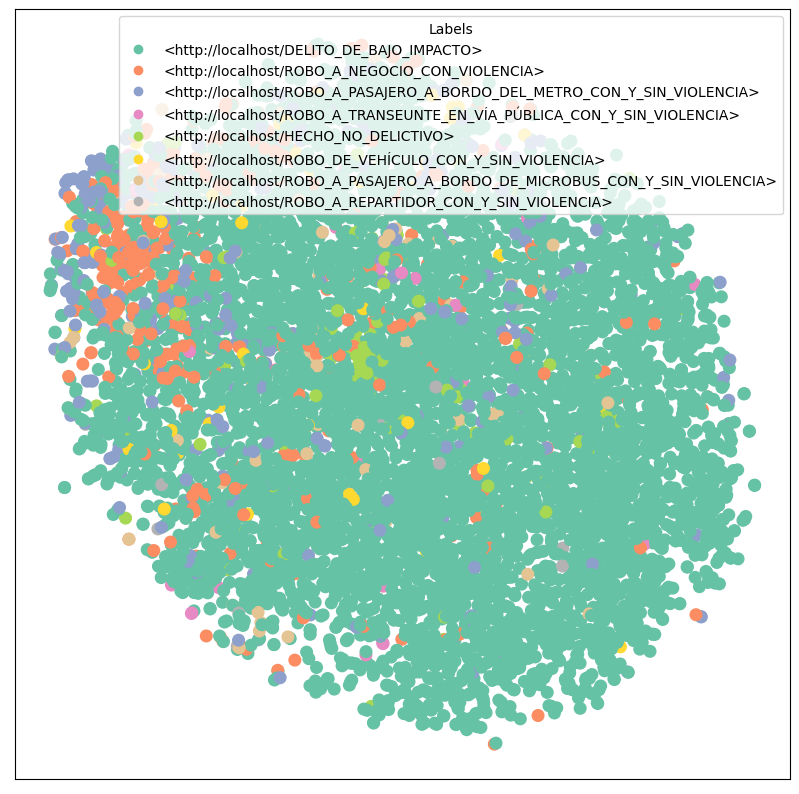

In [420]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)
# visualize(pred[train_idx], labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


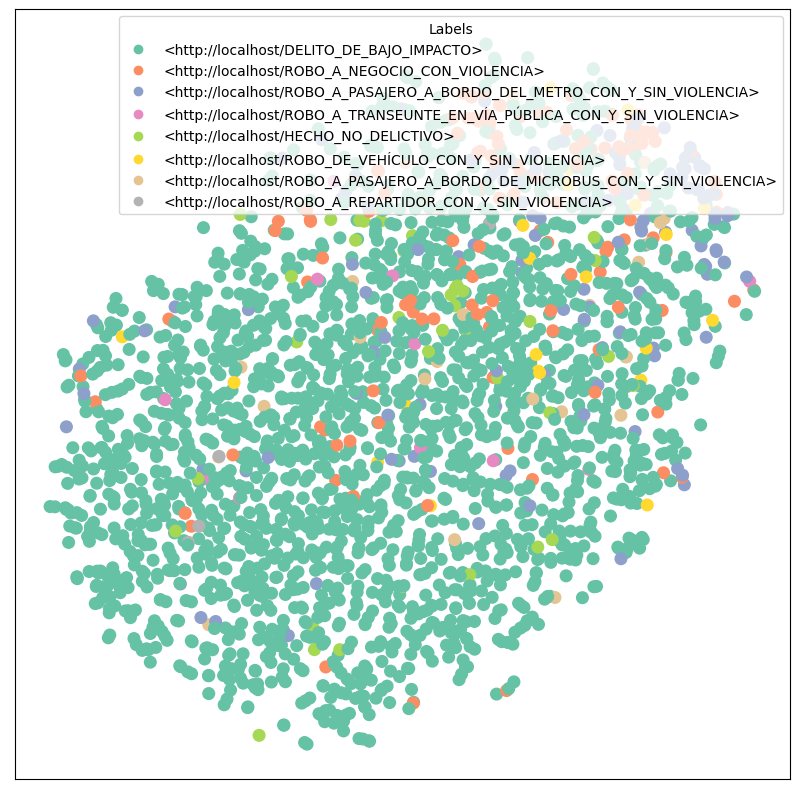

In [421]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

### Entrena la RGCN

In [422]:
device = torch.device('cpu') # ('cuda')
data_device = data_removed_nodes_by_subgraph.to(device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters())
loss_module = torch.nn.BCELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_device.edge_index, data_device.edge_type)
    loss = loss_module(out[train_idx], train_y)
    loss.backward()
    optimizer.step()
    return loss.item()

def accuracy(predictions, y):
    predictions = np.round(predictions)
    return predictions.eq(y).to(torch.float).mean()

@torch.no_grad()
def test():
    model.eval()
    pred = model(data_device.edge_index, data_device.edge_type)
    train_acc = accuracy(pred[train_idx], train_y)
    test_acc = accuracy(pred[test_idx], test_y)
    return train_acc.item(), test_acc.item()

In [423]:
for epoch in range(1, 50):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6899, Train: 0.7831 Test: 0.7743
Epoch: 02, Loss: 0.6685, Train: 0.8131 Test: 0.8050
Epoch: 03, Loss: 0.6490, Train: 0.8322 Test: 0.8262
Epoch: 04, Loss: 0.6272, Train: 0.8417 Test: 0.8361
Epoch: 05, Loss: 0.6058, Train: 0.8470 Test: 0.8416
Epoch: 06, Loss: 0.5864, Train: 0.8501 Test: 0.8448
Epoch: 07, Loss: 0.5650, Train: 0.8524 Test: 0.8470
Epoch: 08, Loss: 0.5414, Train: 0.8546 Test: 0.8496
Epoch: 09, Loss: 0.5227, Train: 0.8568 Test: 0.8521
Epoch: 10, Loss: 0.4980, Train: 0.8593 Test: 0.8567
Epoch: 11, Loss: 0.4767, Train: 0.8619 Test: 0.8625
Epoch: 12, Loss: 0.4541, Train: 0.8657 Test: 0.8720
Epoch: 13, Loss: 0.4322, Train: 0.8752 Test: 0.8869
Epoch: 14, Loss: 0.4097, Train: 0.8943 Test: 0.9073
Epoch: 15, Loss: 0.3914, Train: 0.9212 Test: 0.9354
Epoch: 16, Loss: 0.3696, Train: 0.9448 Test: 0.9599
Epoch: 17, Loss: 0.3500, Train: 0.9612 Test: 0.9732
Epoch: 18, Loss: 0.3322, Train: 0.9719 Test: 0.9766
Epoch: 19, Loss: 0.3114, Train: 0.9773 Test: 0.9772
Epoch: 20, L

### Model visualization

In [424]:
pred = model(edge_index, edge_type[edge_mask])

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


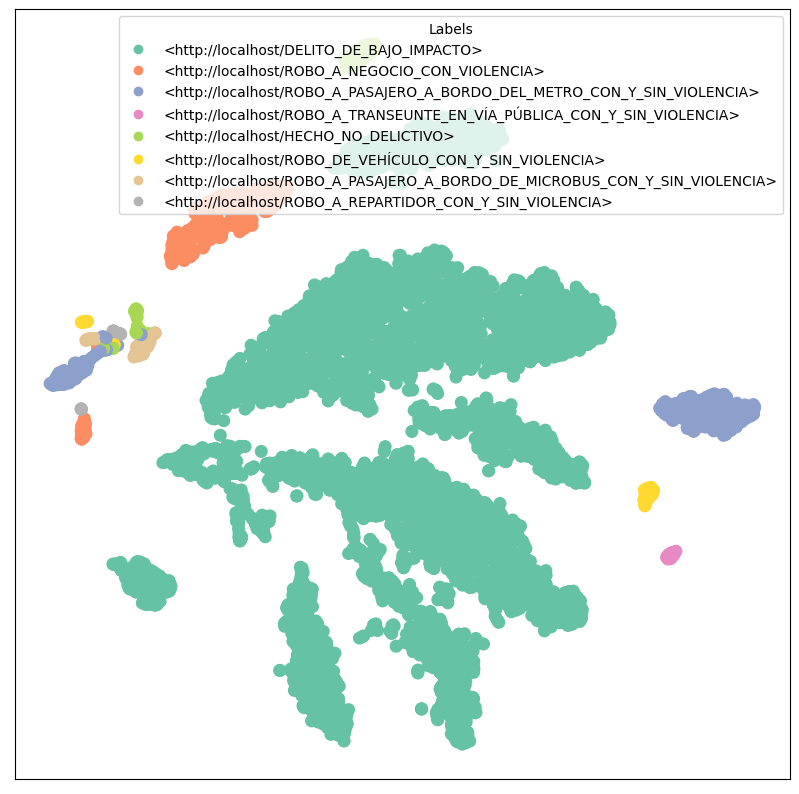

In [425]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


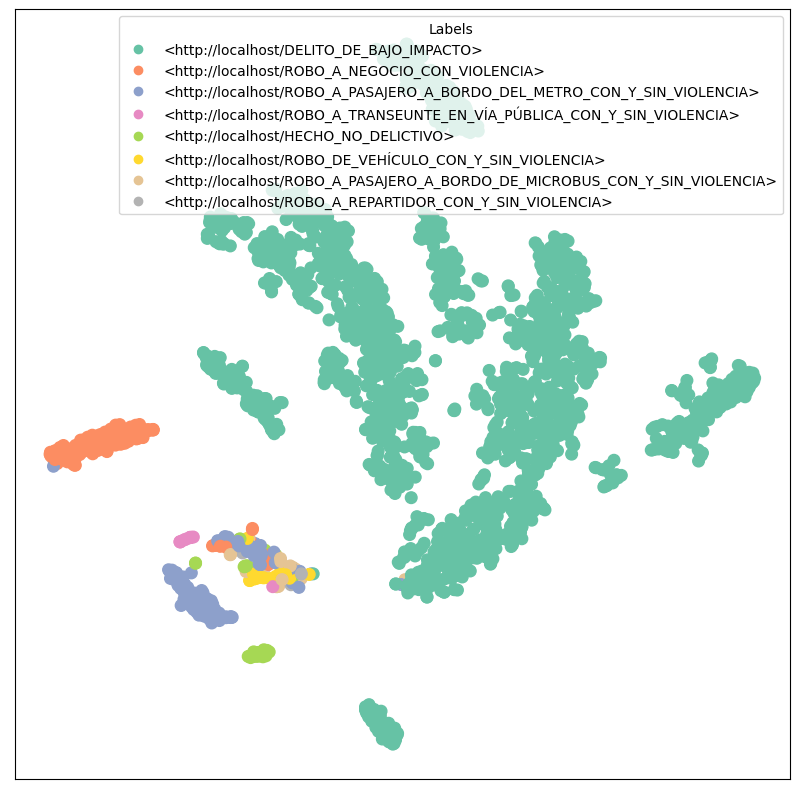

In [426]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

In [427]:
len(pred[test_idx]), len(test_y)

(2499, 2499)

In [432]:
def find(tensor, values):
    return torch.nonzero(tensor[..., None] == values)

In [434]:
test_idx_t = find(node_idx,test_idx)[:,0] ; len(test_idx)

2499

In [435]:
index_t = torch.zeros(node_idx.shape[0], dtype=bool)
index_t[test_idx_t] = True
idx_t = node_idx[index_t]

In [437]:
uris_t = [sg.inverse_transform(i) for i in idx_t]
predicted_labels_t = [l for l in pred[idx_t]]
# extra
predicted_labels_category = [id2label[torch.argmax(x).item()] for x in predicted_labels_t]


In [438]:
real_labels_category = [test_df[test_df['uri'] == uri_pred]['labels'].values[0][0] for uri_pred in uris_t]

In [439]:
predictions_t = list(zip(uris_t, predicted_labels_t, predicted_labels_category, real_labels_category)) ; predictions_t[0:2]

[('<http://localhost/691345>',
  tensor([0.5462, 0.0503, 0.0533, 0.1030, 0.0333, 0.1049, 0.0209, 0.0725, 0.0112,
          0.0160, 0.0155, 0.0069, 0.0087, 0.0134, 0.0472],
         grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>'),
 ('<http://localhost/467795>',
  tensor([0.9154, 0.0167, 0.0087, 0.0266, 0.0254, 0.0071, 0.0065, 0.0168, 0.0045,
          0.0064, 0.0074, 0.0040, 0.0119, 0.0169, 0.0105],
         grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>')]

### Contemos cuantos están bien y cuantos mal

In [440]:
realVsPredList = list()
count = 0
for prediction_t in predictions_t:
    realVsPredList.append(prediction_t[2] == prediction_t[3])
    if prediction_t[2] == prediction_t[3]:
        count += 1


In [445]:
count
len(predictions_t)

2499

In [446]:
predictions_t

[('<http://localhost/691345>',
  tensor([0.5462, 0.0503, 0.0533, 0.1030, 0.0333, 0.1049, 0.0209, 0.0725, 0.0112,
          0.0160, 0.0155, 0.0069, 0.0087, 0.0134, 0.0472],
         grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>'),
 ('<http://localhost/467795>',
  tensor([0.9154, 0.0167, 0.0087, 0.0266, 0.0254, 0.0071, 0.0065, 0.0168, 0.0045,
          0.0064, 0.0074, 0.0040, 0.0119, 0.0169, 0.0105],
         grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>'),
 ('<http://localhost/926982>',
  tensor([0.8798, 0.0196, 0.0101, 0.0238, 0.0207, 0.0081, 0.0070, 0.0160, 0.0043,
          0.0064, 0.0061, 0.0042, 0.0102, 0.0115, 0.0123],
         grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>'),
 ('<http://localhost/562171>',
  tensor([0.9094, 0.0276, 0.0130, 0.0366, 0.02

In [ ]:
# hay que aseguranos que todas las categorias estén presentes en ambos datasets
# Por qué hay muchs nans
# Hacer un conteo de categrias por dataset
# asegurarnos que el split consderve esa relaciónde categorias